In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [51]:
def segmentar_watershed(ruta_imagen):
    # Cargar la imagen
    imagen = cv2.imread(ruta_imagen)
    if imagen is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen en {ruta_imagen}")

    # Convertir a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Umbralizado (Threshold) para separar fondo/objeto.
    #    Usamos Otsu para encontrar un umbral automático.
    #    Dependiendo del fondo, puedes ajustar THRESH_BINARY o THRESH_BINARY_INV.
    _, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Operaciones morfológicas para eliminar ruidos y cerrar pequeños huecos
    kernel = np.ones((3, 3), np.uint8)
    apertura = cv2.morphologyEx(binaria, cv2.MORPH_OPEN, kernel, iterations=2)

    # Determinar el área de fondo "seguro" dilatando la imagen
    fondo_seguro = cv2.dilate(apertura, kernel, iterations=3)

    # Transformada de distancia para encontrar la región "foreground" segura
    dist_transform = cv2.distanceTransform(apertura, cv2.DIST_L2, 5)
    _, fg_seguro = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
    fg_seguro = np.uint8(fg_seguro)

    # Determinar la región desconocida restando fondo_seguro - fg_seguro
    desconocido = cv2.subtract(fondo_seguro, fg_seguro)

    # Etiquetar los componentes conectados (foreground seguro)
    num_objetos, marcadores = cv2.connectedComponents(fg_seguro)

    # Sumar 1 a las etiquetas para que el fondo sea 1 en vez de 0
    marcadores = marcadores + 1

    # Marcar las regiones desconocidas con 0
    marcadores[desconocido == 255] = 0

    # Aplicar Watershed
    marcadores = cv2.watershed(imagen, marcadores)
    # Las fronteras se marcan con -1 en 'marcadores'.

    # Crear el mapa de clases (coloreado):
    #    - fondo (etiquetas <= 1 o -1) se pinta de negro
    #    - cada grano con un color distinto
    mapa_clases = np.zeros_like(imagen, dtype=np.uint8)

    # Determinar la etiqueta máxima
    max_label = marcadores.max()

    # Asignar un color aleatorio para cada etiqueta > 1
    colores = {}
    for etiqueta in range(2, max_label+1):
        colores[etiqueta] = [
            random.randint(50, 255),  # B
            random.randint(50, 255),  # G
            random.randint(50, 255)   # R
        ]

    # Rellenar el mapa de clases
    for i in range(marcadores.shape[0]):
        for j in range(marcadores.shape[1]):
            etiqueta = marcadores[i, j]
            if etiqueta > 1:
                mapa_clases[i, j] = colores[etiqueta]
            else:
                mapa_clases[i, j] = [0, 0, 0]  # fondo/ frontera en negro

    # Combinar la imagen original con el mapa de clases "pálido"
    alpha = 0.8 
    mapa_clases_palida = (mapa_clases * alpha).astype(np.uint8)
    resultado = cv2.addWeighted(imagen, 0.6, mapa_clases_palida, 1.7, 0)

    return binaria, mapa_clases, resultado


In [52]:
ruta_imagen = "wheat.png"

In [53]:
# Llamamos a la función de segmentación
binaria, mapa_clases, resultado = segmentar_watershed(ruta_imagen)

In [54]:
# Convertir imágenes a RGB 
binaria_rgb = cv2.cvtColor(binaria, cv2.COLOR_GRAY2RGB)
mapa_clases_rgb = cv2.cvtColor(mapa_clases, cv2.COLOR_BGR2RGB)
resultado_rgb = cv2.cvtColor(resultado, cv2.COLOR_BGR2RGB)

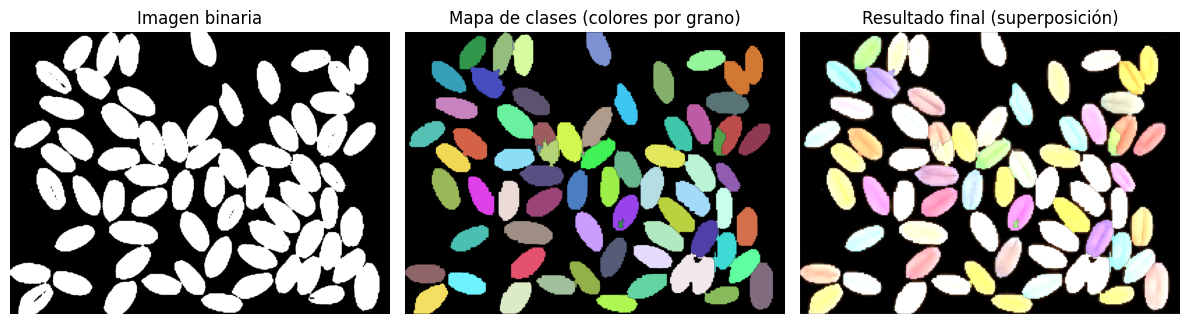

In [55]:
 # Mostrar los resultados
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen binaria")
plt.imshow(binaria_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Mapa de clases (colores por grano)")
plt.imshow(mapa_clases_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Resultado final (superposición)")
plt.imshow(resultado_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()